<a href="https://colab.research.google.com/github/rage-against-the-machine-learning/cs7643-DL-Group-Project/blob/louis/CNN_AE_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!wget https://cs7643-raml.s3.us-west-2.amazonaws.com/valid_subset_np_imgs.zip

--2021-08-03 16:54:03--  https://cs7643-raml.s3.us-west-2.amazonaws.com/valid_subset_np_imgs.zip
Resolving cs7643-raml.s3.us-west-2.amazonaws.com (cs7643-raml.s3.us-west-2.amazonaws.com)... 52.92.164.98
Connecting to cs7643-raml.s3.us-west-2.amazonaws.com (cs7643-raml.s3.us-west-2.amazonaws.com)|52.92.164.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2915042448 (2.7G) [application/zip]
Saving to: ‘valid_subset_np_imgs.zip.1’

valid_subset_np_img 100%[===================>]   2.71G  26.7MB/s    in 97s     

2021-08-03 16:55:41 (28.6 MB/s) - ‘valid_subset_np_imgs.zip.1’ saved [2915042448/2915042448]



In [40]:
!unzip valid_subset_np_imgs.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid_subset/COCO_val2014_000000576754.np  
  inflating: valid_subset/COCO_val2014_000000104625.np  
  inflating: valid_subset/COCO_val2014_000000223751.np  
  inflating: valid_subset/COCO_val2014_000000202438.np  
  inflating: valid_subset/COCO_val2014_000000113533.np  
  inflating: valid_subset/COCO_val2014_000000454601.np  
  inflating: valid_subset/COCO_val2014_000000377427.np  
  inflating: valid_subset/COCO_val2014_000000301963.np  
  inflating: valid_subset/COCO_val2014_000000198447.np  
  inflating: valid_subset/COCO_val2014_000000234238.np  
  inflating: valid_subset/COCO_val2014_000000296969.np  
  inflating: valid_subset/COCO_val2014_000000528488.np  
  inflating: valid_subset/COCO_val2014_000000250301.np  
  inflating: valid_subset/COCO_val2014_000000254625.np  
  inflating: valid_subset/COCO_val2014_000000375621.np  
  inflating: valid_subset/COCO_val2014_000000450370.np  
  inflating: valid_subset/COCO_val201

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import collections
import pickle

In [2]:
mypath = '/content/valid_subset/'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]


In [3]:
images = []
for f in files:
  images.append(np.load('/content/valid_subset/'+f))
print(len(images))


21002


In [ ]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = images[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    
plt.show()

In [4]:
# images N * 224 * 224 * 3
images = np.transpose(np.array(images),(0,3,1,2))

In [5]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("GPU!")
else:  
  dev = "cpu"  
device = torch.device(dev) 

GPU!


In [6]:
import gc
gc.collect()

566

In [7]:
dev_images = torch.FloatTensor(images).to(device)

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4),
            nn.MaxPool2d(kernel_size=(3,3))
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Upsample((112,112)),
            nn.ConvTranspose2d(128, 1, 3, stride=2, padding=1, output_padding=1),
          
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (7): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1

In [9]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
         MaxPool2d-2           [-1, 16, 56, 56]               0
              ReLU-3           [-1, 16, 56, 56]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
         MaxPool2d-5             [-1, 32, 9, 9]               0
              ReLU-6             [-1, 32, 9, 9]               0
            Conv2d-7             [-1, 64, 6, 6]          32,832
         MaxPool2d-8             [-1, 64, 2, 2]               0
   ConvTranspose2d-9             [-1, 32, 5, 5]          32,800
             ReLU-10             [-1, 32, 5, 5]               0
  ConvTranspose2d-11           [-1, 64, 10, 10]          18,496
             ReLU-12           [-1, 64, 10, 10]               0
  ConvTranspose2d-13          [-1, 128, 20, 20]          73,856
             ReLU-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
# specify loss function
criterion = nn.MSELoss().to(device)

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainloader = DataLoader(
    dev_images, 
    batch_size=64,
    shuffle=True
)

In [11]:
# number of epochs to train the model
n_epochs = 30
outputs = []
losses = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in trainloader:
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    # print avg training statistics 
    train_loss = train_loss/len(trainloader)
    outputs.append((epoch, data, output),)
    losses.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64, 3, 224, 224])) that is different to the input size (torch.Size([64, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 3, 224, 224])) that is different to the input size (torch.Size([10, 1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	Training Loss: 54.767868
Epoch: 2 	Training Loss: 38.197986
Epoch: 3 	Training Loss: 35.701396
Epoch: 4 	Training Loss: 34.390037
Epoch: 5 	Training Loss: 33.535656
Epoch: 6 	Training Loss: 32.926281
Epoch: 7 	Training Loss: 32.480341
Epoch: 8 	Training Loss: 32.123276
Epoch: 9 	Training Loss: 31.795629
Epoch: 10 	Training Loss: 31.585063
Epoch: 11 	Training Loss: 31.370730
Epoch: 12 	Training Loss: 31.184901
Epoch: 13 	Training Loss: 31.033074
Epoch: 14 	Training Loss: 30.865063
Epoch: 15 	Training Loss: 30.759468
Epoch: 16 	Training Loss: 30.596429
Epoch: 17 	Training Loss: 30.513371
Epoch: 18 	Training Loss: 30.376035
Epoch: 19 	Training Loss: 30.327179
Epoch: 20 	Training Loss: 30.188999
Epoch: 21 	Training Loss: 30.132448
Epoch: 22 	Training Loss: 30.023906
Epoch: 23 	Training Loss: 29.949479
Epoch: 24 	Training Loss: 29.947680
Epoch: 25 	Training Loss: 29.830713
Epoch: 26 	Training Loss: 29.793411
Epoch: 27 	Training Loss: 29.742027
Epoch: 28 	Training Loss: 29.673100
E

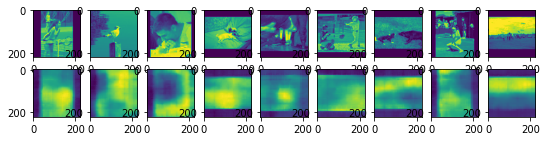

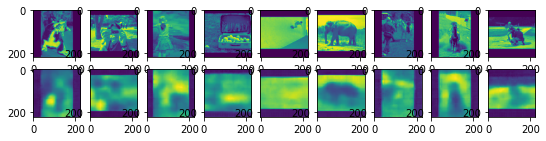

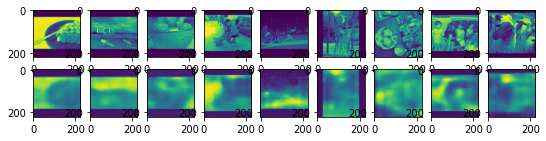

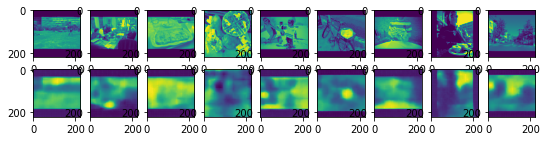

In [12]:
for k in range(0, 20, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].cpu().detach().numpy()

    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [13]:
import gc
gc.collect()

124659

In [14]:
devloader = DataLoader(
    images, 
    batch_size=64,
    shuffle=True
)

In [15]:
from tqdm import tqdm

In [16]:
features_lists = []
i = 0
for batch in tqdm(devloader):
  batch = torch.FloatTensor(batch)
  batch = torch.stack([batch])
  with torch.no_grad():
    features_batch = model.cpu().encoder(batch[0]).flatten(start_dim=1)
    features_lists.append(features_batch)
 

100%|██████████| 329/329 [00:30<00:00, 10.82it/s]


In [17]:
img_emb = collections.defaultdict(list)
img_id = 0
for batch in features_lists:
  for emb in batch:
    img_emb[img_id] = emb.tolist()
    img_id += 1


In [18]:
# import json
# with open('val_img_emb.json', 'w') as fp:
#     json.dump(img_emb, fp)

In [20]:
!pip install annoy

In [21]:
len(img_emb[0])

256

In [22]:
from annoy import AnnoyIndex
import random

f = 256
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
for i in range(len(img_emb)):
    t.add_item(i, img_emb[i])

t.build(20) # 10 trees


True

In [23]:
t.save('test.ann')

# ...

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file

True

In [24]:
images.shape


(21002, 3, 224, 224)

In [25]:
from annoy import AnnoyIndex
import random

f = 256
t = AnnoyIndex(f, 'angular') 
for i in range(len(img_emb)):
    t.add_item(i, img_emb[i])
t.build(10) # 10 trees
t.save('test.ann')

u = AnnoyIndex(f, 'angular')
u.load('test.ann') 
def id2img(image_id):
  a = images[image_id]
  imgs = torch.FloatTensor(a).permute(1, 2, 0).numpy()
  #print("original image id :", image_id)
  #plt.imshow(imgs)
  #plt.show()
  sim_imgs = u.get_nns_by_item(image_id, 11)
  return sim_imgs
  # print("similar images ids:", sim_imgs)
  # for img in sim_imgs:
  #   if img==img_id:
  #     continue
  #   a = images[img]
  #   imgs = torch.FloatTensor(a).permute(1, 2, 0).numpy()
  #   plt.imshow(imgs)
  #   plt.show()

  

In [26]:
read_dictionary = np.load('id_imagecocoid_mapping.npy',allow_pickle='TRUE').item()

In [27]:
with open('id_imagecocoid_mapping.json', 'wb') as fp:
    pickle.dump(read_dictionary, fp)

In [28]:
%time
id2img(12661)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


[12661, 1679, 17490, 5868, 10531, 16987, 16221, 751, 17384, 12652, 579]

In [29]:
def nearestNeighbor(img_id,k):
  distances = []
  img_i = img_emb[img_id]
  for i,emb in img_emb.items():
    if i==img_id:
      continue
    cos = np.dot(img_i,emb)
  
    distances.append([cos,i])
 # print(distances[0])
  rec = []
  for i in sorted(distances,key=lambda x:-x[0])[:k]:
    rec.append(i[1])
  a = images[img_id]
  imgs = torch.FloatTensor(a).permute(1, 2, 0).numpy()
 # print("original image id :", img_id)
 # plt.imshow(imgs)
#  plt.show()
  # for img in rec:
  #   if img==img_id:
  #     continue
  #   a = images[img]
  #   imgs = torch.FloatTensor(a).permute(1, 2, 0).numpy()
  #   plt.imshow(imgs)
  #   plt.show()

  return rec


In [30]:
nearestNeighbor(12661,10)

[496, 17156, 9191, 15450, 5956, 15903, 4621, 18287, 3415, 17875]

In [31]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [32]:
!wget https://cs7643-raml.s3.us-west-2.amazonaws.com/annotations/instances_val2014.json

--2021-08-03 17:31:52--  https://cs7643-raml.s3.us-west-2.amazonaws.com/annotations/instances_val2014.json
Resolving cs7643-raml.s3.us-west-2.amazonaws.com (cs7643-raml.s3.us-west-2.amazonaws.com)... 52.218.252.225
Connecting to cs7643-raml.s3.us-west-2.amazonaws.com (cs7643-raml.s3.us-west-2.amazonaws.com)|52.218.252.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160682675 (153M) [application/json]
Saving to: ‘instances_val2014.json.1’

instances_val2014.j 100%[===================>] 153.24M  23.9MB/s    in 6.7s    

2021-08-03 17:31:59 (22.9 MB/s) - ‘instances_val2014.json.1’ saved [160682675/160682675]



In [33]:
# initialize COCO api for instance annotations
coco=COCO('/content/instances_val2014.json')

loading annotations into memory...
Done (t=8.54s)
creating index...
index created!


In [34]:
categories = coco.loadCats(coco.getCatIds())

In [35]:
 # Animal,  Sports,  and Food
 import collections
 categories_consol = collections.defaultdict(dict)

for category_meta in categories:
    categories_consol[category_meta['supercategory']].update({ category_meta['name']: category_meta['id']})

In [36]:
def imageid2catid(image_id):
  annIds = coco.getAnnIds(imgIds=image_id, iscrowd=None)
  anns = coco.loadAnns(annIds)
  cats = collections.defaultdict(int)
  for a in anns:
    cats[a['category_id']] += 1
  category_id = list({k: v for k, v in sorted(cats.items(), key=lambda item: -item[1])}.keys())[0]
  # subcats = []
  # for a in anns:
  #   print(a['category_id'])
  #   for sub_cat in categories_consol[a['category_id']]:
  #     print(sub_cat)
   # scats = subcats.extend(categories_consol[a['category_id']].keys())
#  subcat_id = collections.Counter(scats).most_common()
  return category_id



In [82]:
def imageid2subcatid(image_id):
  annIds = coco.getAnnIds(imgIds=image_id, iscrowd=None)
  anns = coco.loadAnns(annIds)
  cats = []
  for a in anns:
    cats.append(a['category_id'])
  subcats = []
  for c in cats:
    #for subcat in plotter.cats_dict[c]['name']:
    subcats.append(plotter.cats_dict[c]['name'])
 # print(subcats#)
  return collections.Counter(subcats).most_common()[0][0] if subcats else 'None'



In [83]:
imageid2subcatid(read_dictionary[0])

'surfboard'

In [93]:
# working on the recall
# 1. from id to coco id
# 2. from coco id to cat id
# recall @ k = 4; recall = tp / tp+fn

def calculate_recall_cat_annoy(img_id):
  coco_id = read_dictionary[img_id]
  img_cat = imageid2subcatid(coco_id)

  annoy_nn_ids_coco = [read_dictionary[i] for i in nearestNeighbor(img_id,11)]
 # print(img_cat)
  nn_cats = []
  for i in annoy_nn_ids_coco:
    nn_cats.append(imageid2subcatid(i))
#  print(nn_cats)
 # print(img_cat,nn_cats)
  nn_cats = nn_cats[1:]
  tp = sum([1 for cat in nn_cats[:4] if cat == img_cat])
  fp = sum([1 for cat in nn_cats[:4] if cat != img_cat])
  relevant = sum([1 for cat in nn_cats if cat == img_cat])
#  print(tp,fp,relevant)
  return round(tp/(relevant+1e-6),4), round(tp/(tp+fp+1e-6),4)

In [91]:
calculate_recall_cat_annoy(1)

ZeroDivisionError: ignored

In [95]:
r = 0
p = 0
for i in range(len(images)):
  pi,ri= calculate_recall_cat_annoy(i)
  p += pi
  r += ri
print(p/len(images))
print(r/len(images))

0.1895116
0.1395


In [42]:
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import numpy as np
import itertools
from pycocotools.coco import COCO
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import pandas as pd

class EmbeddingPlotter:
    def __init__(self, annot_file, idx2Img):
        self.annot_file = annot_file
        self.coco = COCO(self.annot_file)
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.cat_id_to_name_dict = {cat['id']: cat['name'] for cat in cats}
        self.img_ids = list(idx2Img.values())
        self.annIds = self.coco.getAnnIds(self.img_ids)
        #self.labels = [self.coco.loadAnns(self.annIds)]
        
        
        
        self.idx2Img = idx2Img
        self.labels = []
        for k, v in self.idx2Img.items():
            ann_ids_to_append = self.coco.getAnnIds(self.idx2Img[k])
            anns_to_append = self.coco.loadAnns(ann_ids_to_append)
            self.labels.append(anns_to_append)
            
        
        self.category_labels=[]
        # self.category_multi_labels = []
        # self.category_multi_labels_counts = []
        self.supercategory_labels = []
        # self.supercategory_multi_labels = []
        # self.supercategory_multi_labels_counts = []
        
        
 
        
        self.cats_dict = {cat['id']: cat for cat in cats}
        for label in self.labels:
            
            if len(label) > 0:
                categories = []
                supercategories = []
                
                for annotation in label:
                    categories.append(self.cats_dict[annotation['category_id']]['name'])
                    supercategories.append(self.cats_dict[annotation['category_id']]['supercategory'])
                # self.category_multi_labels_counts.append(categories)
                # self.category_multi_labels.append(list(set(categories)))
                # self.supercategory_multi_labels.append(list(set(supercategories)))
                # self.supercategory_multi_labels_counts.append(supercategories)
        
                # most common category among objects in the picture
                category, _ = Counter(categories).most_common(1)[0]
                supercategory, _ = Counter(supercategories).most_common(1)[0]
                
                self.category_labels.append(category)
                self.supercategory_labels.append(supercategory)
            else:
                # self.supercategory_multi_labels.append([])
                # self.supercategory_multi_labels_counts.append([])
                # self.category_multi_labels.append([])
                # self.category_multi_labels_counts.append([])
                self.category_labels.append(None)
                self.supercategory_labels.append(None)

In [43]:
plotter = EmbeddingPlotter('/content/instances_val2014.json',read_dictionary)

loading annotations into memory...
Done (t=5.16s)
creating index...
index created!


In [96]:
plotter.category_labels

['surfboard',
 'car',
 'person',
 'person',
 'person',
 'elephant',
 'sports ball',
 'cat',
 'person',
 'person',
 'cow',
 'dog',
 'bird',
 'car',
 'person',
 'chair',
 'bottle',
 'person',
 'person',
 'giraffe',
 'cat',
 'dog',
 'horse',
 'bird',
 'bird',
 'sandwich',
 'chair',
 'person',
 'cow',
 'horse',
 'person',
 'person',
 'person',
 'potted plant',
 'cake',
 'dog',
 'banana',
 'person',
 'sandwich',
 'spoon',
 'dog',
 'elephant',
 'person',
 'person',
 'wine glass',
 'dog',
 'bottle',
 'car',
 'person',
 'potted plant',
 'person',
 'apple',
 'person',
 'surfboard',
 'surfboard',
 'surfboard',
 'cow',
 'bird',
 'cow',
 'broccoli',
 'skis',
 'bird',
 'dining table',
 'person',
 'dog',
 'person',
 'person',
 'person',
 'zebra',
 'person',
 'person',
 'knife',
 'sports ball',
 'person',
 'dog',
 'vase',
 'dog',
 'bowl',
 'kite',
 'person',
 'person',
 'bottle',
 'person',
 'bench',
 'cat',
 'person',
 'giraffe',
 'broccoli',
 'broccoli',
 'chair',
 'book',
 'person',
 'carrot',
 'p